In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import cv2
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision import models

In [ ]:
from pathlib import Path
%pip install -q gdown

data_path = Path("/Users/namnguyenvu/Desktop/University Documents/Third Year (2023-2024)/Fall 2023 Semester/CPSC 599.6")
image_path = data_path
zip_path = data_path / "Assignment3Dataset.zip"

if zip_path.exists():
  print("The zip file Assignment3Dataset existed")
else:
  !gdown -q --id 1AEfZ5tBBRLVbCh7Y0mibR0C9jca8jiKo -O Assignment3Dataset.zip

  # I download the zip file from D2L and put in my Google Drive
  # The link is https://drive.google.com/file/d/1AEfZ5tBBRLVbCh7Y0mibR0C9jca8jiKo/view?usp=sharing
  # if image_path.is_dir():
  #   print("The unzipped folder Assignment3Dataset existed")
  # else:
  #   !unzip Assignment3Dataset.zip
!unzip -oq Assignment3Dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [ ]:
import pandas as pd
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.transform = transforms.Compose([
                                transforms.ToTensor()])
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path)
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load the full dataset
full_dataset = CustomImageDataset('train.csv')

# Determine the lengths of the splits
train_len = int(0.8 * len(full_dataset))
valid_len = len(full_dataset) - train_len

# Create the random splits
train_dataset, valid_dataset = random_split(full_dataset, [train_len, valid_len])

# Apply the transformations to the datasets
train_dataset.dataset.transform = transforms.Compose([transforms.Resize((400, 400)),
                                                      transforms.RandomHorizontalFlip(),
                                                      transforms.RandomRotation(15),
                                                      transforms.ToTensor(),
                                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

valid_dataset.dataset.transform = transforms.Compose([transforms.Resize((400, 400)),
                                                    #  transforms.RandomRotation(15),
                                                     transforms.ToTensor(),
                                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
print(train_dataset[0][1])
print(len(valid_dataset))

10
827


In [ ]:
def visualize(image, label):
  image = image.permute(1, 2, 0)
  image = image.numpy()
  plt.figure()
  plt.imshow(image)
  plt.title(str(label))
  plt.xticks([])
  plt.yticks([])


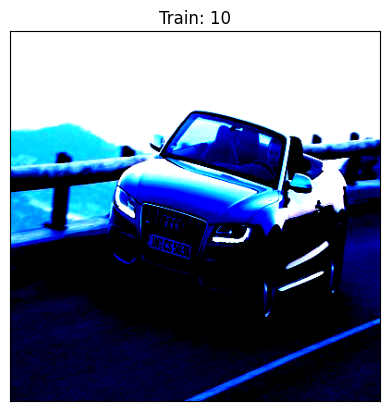

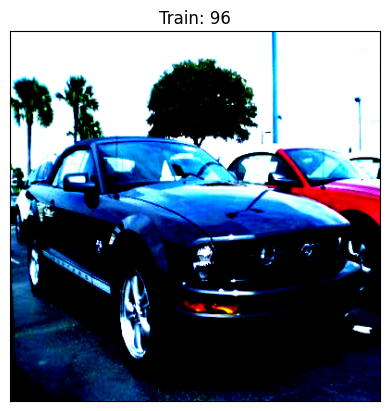

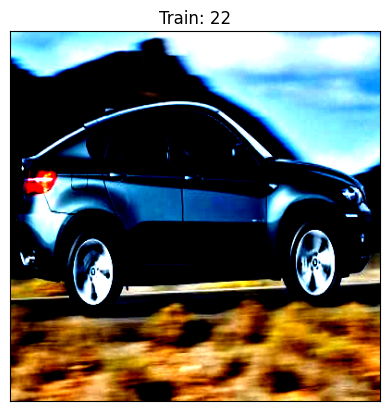

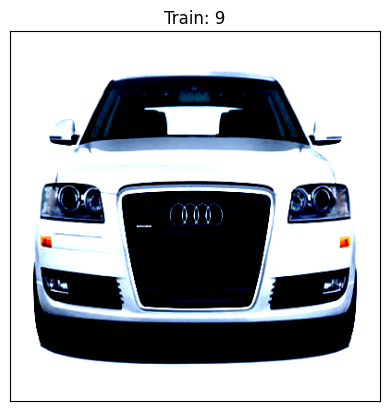

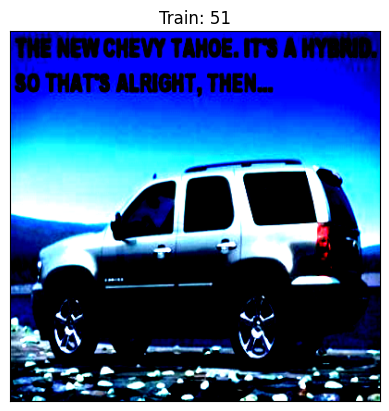

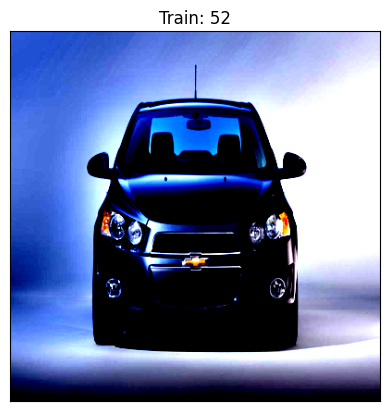

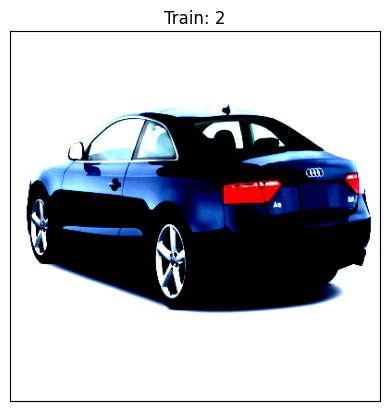

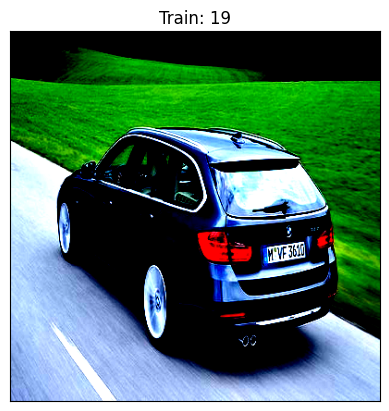

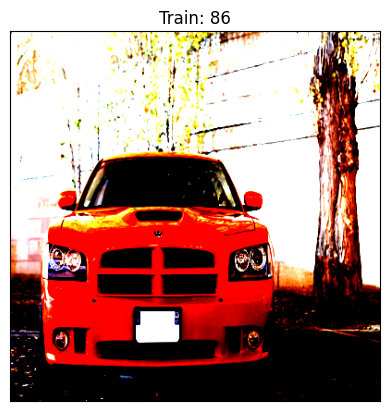

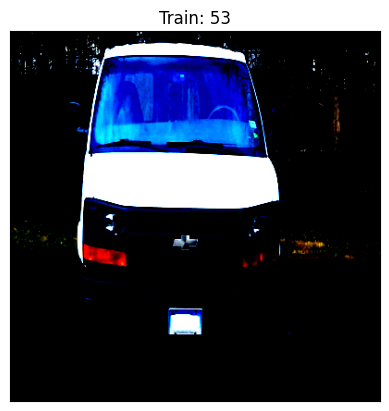

In [ ]:
train_examples = [train_dataset[i] for i in range(10)]
for image, label in train_examples:
  visualize(image, f'Train: {label}')

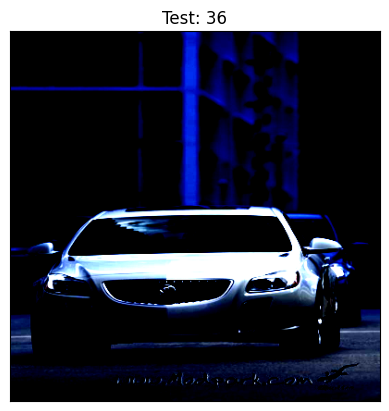

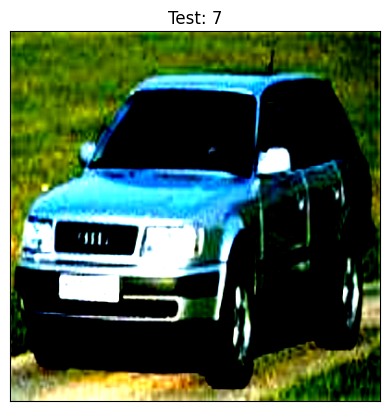

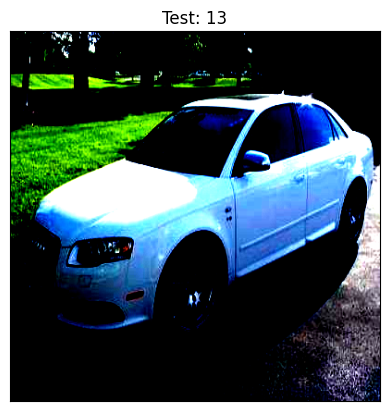

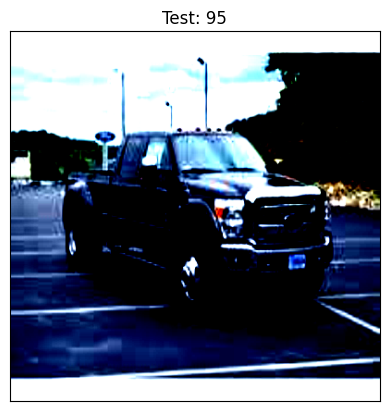

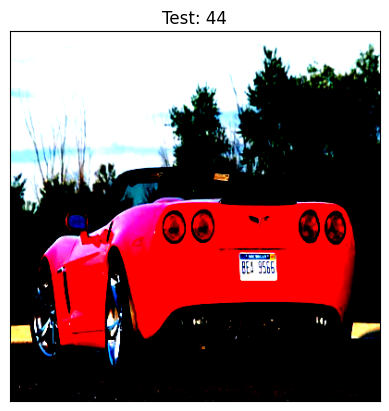

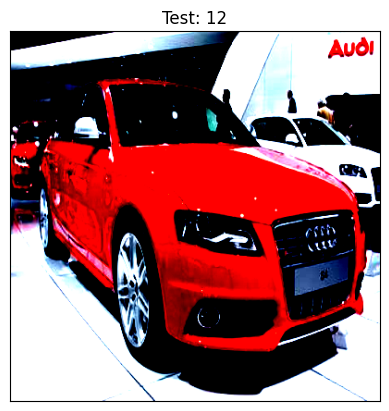

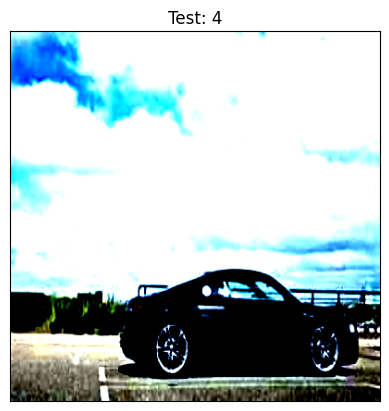

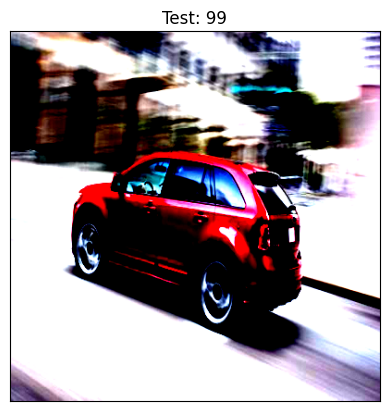

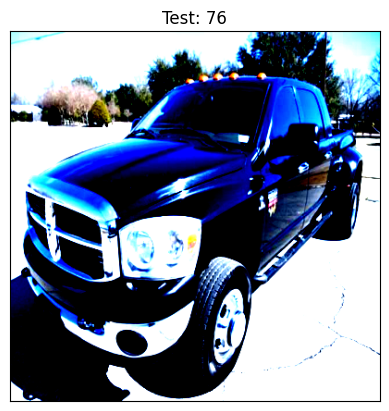

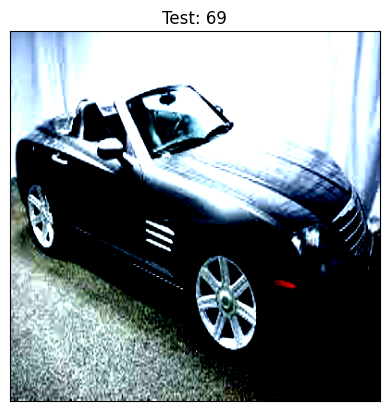

In [ ]:
valid_examples = [valid_dataset[i] for i in range(10)]
for image, label in valid_examples:
  visualize(image, f'Validation: {label}')


In [ ]:
# We don't use freezing but I just put here in case we have to
def freeze(model):
  for param in model.parameters():
    param.requires_grad = False

# unfreeze the parameters of the first layer
def unfreeze(model):
  for param in model.layer1.parameters():
    param.requires_grad = True

In [ ]:
if (torch.cuda.is_available()):
  device = "cuda"
else:
  device = "cpu"
print(device)

cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model.fc = nn.Linear(num_ftrs, 100)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 79.0MB/s]


In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

In [ ]:
def evaluation(model, loader, criterion, device, phase='Valid'):
  model.eval()
  predictions = []
  ground_truth = []
  with torch.no_grad():
    total_loss = 0
    total  = 0
    correct = 0
    for batch_index, (images, labels) in enumerate(loader):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds.cpu().numpy())
      ground_truth.extend(labels.cpu().numpy())
      correct += (preds == labels).sum().item()
    accuracy = correct / total
    loss = total_loss / total
    print(f'     {phase} Accuracy={accuracy:<10.4f}  Loss= {loss:<10.4f}')
    return {'loss': loss,
            'accuracy': accuracy,
            'ground_truth': ground_truth,
            'predictions': predictions}

In [ ]:
def training(model, train_loader, valid_loader, criterion, optimizer, device,
             epochs, best_model_path):
  model.train()
  best_loss = torch.inf
  best_restults = None
  for epoch in range(epochs):
    total_loss = 0
    total  = 0
    correct = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      optimizer.zero_grad()
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      if hasattr(outputs, 'logits'):
        outputs = outputs.logits
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()
    accuracy = correct / total
    loss = total_loss / total
    print(f'{epoch:<4} Train Accuracy={accuracy:<10.4f}  Loss= {loss:<10.4f}')
    results = evaluation(model, valid_loader, criterion, device)
    test_acc = results['accuracy']
    scheduler = lrscheduler

    model.train()
    scheduler.step(test_acc)

    if results['loss'] < best_loss:
      best_model = model.state_dict()
      torch.save(best_model, best_model_path)
      best_loss = results['loss']
      best_restults = results
    print()
  return best_restults

In [ ]:
epochs = 60
best_model_path = 'best_model.pt'
best_restults = training(model, train_loader, valid_loader, criterion,
                         optimizer, device, epochs, best_model_path)

0    Train Accuracy=0.1641      Loss= 3.5689    
     Valid Accuracy=0.2576      Loss= 2.9782    


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



1    Train Accuracy=0.6454      Loss= 1.2712    
     Valid Accuracy=0.5949      Loss= 1.3330    

2    Train Accuracy=0.8957      Loss= 0.4783    
     Valid Accuracy=0.8029      Loss= 0.6215    

3    Train Accuracy=0.9640      Loss= 0.2359    
     Valid Accuracy=0.8525      Loss= 0.5108    

4    Train Accuracy=0.9885      Loss= 0.1471    
     Valid Accuracy=0.8537      Loss= 0.4927    

5    Train Accuracy=0.9924      Loss= 0.1114    
     Valid Accuracy=0.8585      Loss= 0.4819    

6    Train Accuracy=0.9952      Loss= 0.0869    
     Valid Accuracy=0.8549      Loss= 0.4718    

7    Train Accuracy=0.9973      Loss= 0.0686    
     Valid Accuracy=0.8646      Loss= 0.4611    

8    Train Accuracy=0.9976      Loss= 0.0544    
     Valid Accuracy=0.8622      Loss= 0.4697    

9    Train Accuracy=0.9979      Loss= 0.0455    
     Valid Accuracy=0.8573      Loss= 0.4536    

10   Train Accuracy=0.9982      Loss= 0.0432    
     Valid Accuracy=0.8609      Loss= 0.4645    

11   Trai

## Testing the best model


In [ ]:
import csv
import torch
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torchvision import models
import torch.nn as nn
import random

# Define your transform
transforms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transform = transforms

# Define your model
model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model.fc = nn.Linear(num_ftrs, 100)
model = model.to(device)


# Load the state dict previously saved
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)

# Ensure model is in eval mode for inference
model.eval()

df = pd.read_csv('sample.csv')

# Loop through each row and update predictions
for index, row in df.iterrows():
    image_path = os.path.join("/content", row['id'])
    image = Image.open(image_path)
    image = transform(image)
    image = torch.autograd.Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Make prediction
    # with torch.no_grad():
    #     output = model(image)
    output = model(image)

    prediction = torch.argmax(output).item()

    # Update the 'Predicted' column
    df.at[index, 'Predicted'] = prediction

# Save the updated DataFrame to a new CSV file
df.to_csv('updated_sample.csv', index=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
